<a href="https://colab.research.google.com/github/vimesh630/ML_CW/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive and Import Libraries

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and Merge Datasets

In [2]:
# Load the datasets from Google Drive
file_path_full = '/content/drive/MyDrive/ML Coursework/bank+marketing/bank-additional/bank-additional/bank-additional-full.csv'
file_path_subset = '/content/drive/MyDrive/ML Coursework/bank+marketing/bank-additional/bank-additional/bank-additional.csv'

# Load both datasets
df_full = pd.read_csv(file_path_full, sep=';')
df_subset = pd.read_csv(file_path_subset, sep=';')

# Check if both datasets have the same structure
if df_full.columns.equals(df_subset.columns):
    print("Both datasets have the same structure. Merging...")
    df = pd.concat([df_full, df_subset], ignore_index=True)
else:
    print("Datasets have different structures. Using `bank-additional-full.csv` for preprocessing.")
    df = df_full

Both datasets have the same structure. Merging...


Handle Missing Values

In [3]:
# Replace "unknown" with NaN and log the affected columns
df.replace('unknown', np.nan, inplace=True)

# Drop columns with more than 30% missing values
missing_threshold = 0.3
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index
df.drop(columns=columns_to_drop, inplace=True)

# Fill remaining missing values
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical columns with mode
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].mean(), inplace=True)  # Fill numeric columns with mean

<ipython-input-3-f0a645ded39e>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical columns with mode
<ipython-input-3-f0a645ded39e>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

# Visualizations

Target Variable Distribution

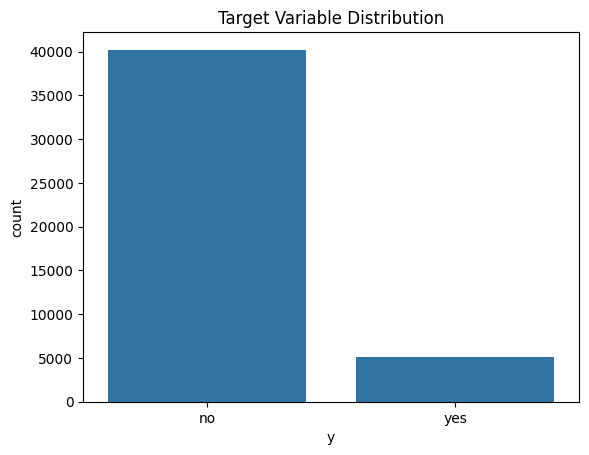

In [4]:
sns.countplot(data=df, x='y')
plt.title('Target Variable Distribution')
plt.show()

Feature Correlation Heatmap

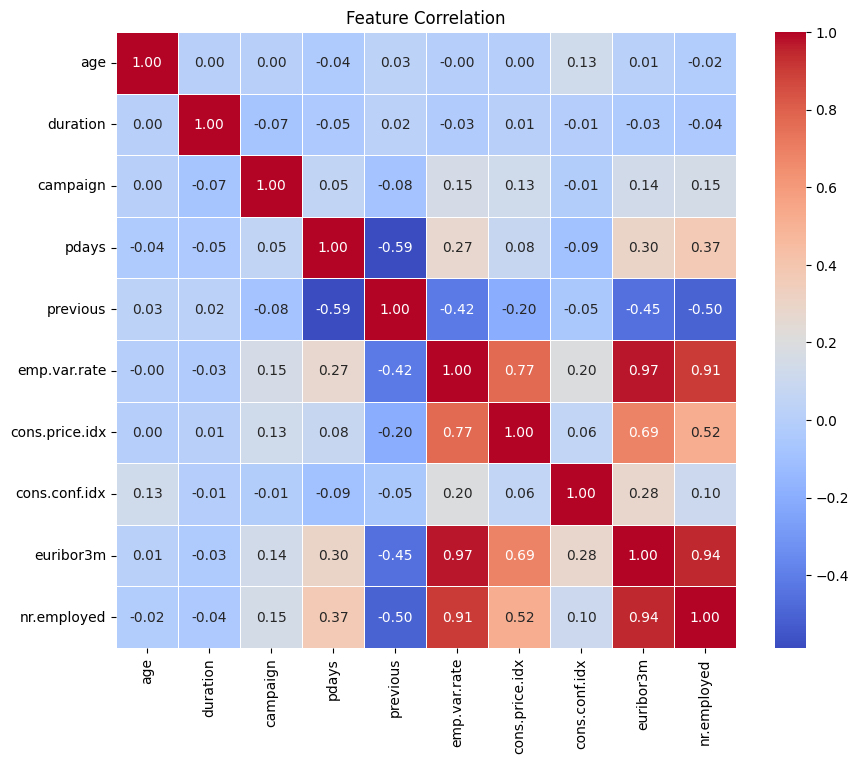

In [5]:
# Ensure all non-numeric columns are excluded
numeric_data = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation')
plt.show()

Numerical Features Distribution

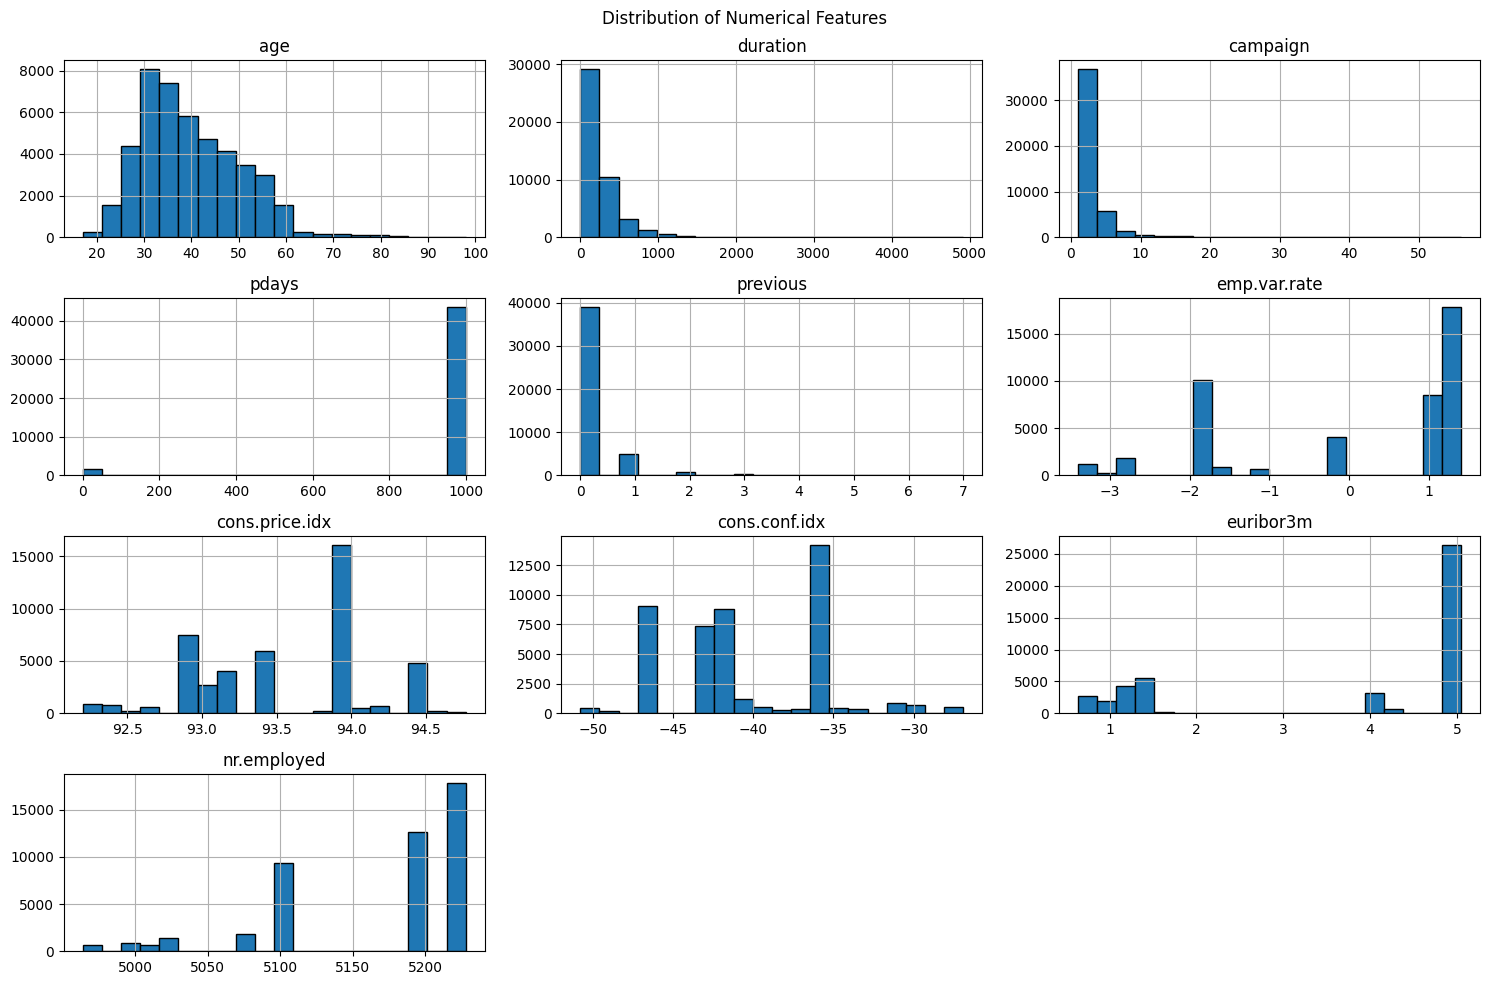

In [6]:
# Plotting histograms for all numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

Scale Numerical Features

In [7]:
# Scale numeric features using StandardScaler
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

Seperate Features and Target

In [8]:
# Separate features and target
X = df.drop('y', axis=1)
y = df['y']

Apply SMOTE for Balancing

In [10]:
# Ensure all features are numeric
X = pd.get_dummies(X, drop_first=True)

# Ensure the target is numeric
y = y.map({'yes': 1, 'no': 0})

# Check target distribution before balancing
print("Target distribution before balancing:", y.value_counts())

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new target distribution
print("Target distribution after balancing:", np.bincount(y_resampled))

Target distribution before balancing: y
0    40216
1     5091
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Target distribution after balancing: [40216 40216]


Split and Save Data

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Save preprocessed data for future use
X_train.to_csv('/content/drive/MyDrive/ML Coursework/Preprocessed Dataset/X_train.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/ML Coursework/Preprocessed Dataset/y_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/ML Coursework/Preprocessed Dataset/X_test.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/ML Coursework/Preprocessed Dataset/y_test.csv', index=False)

# Verify the preprocessed training data
print("Sample of preprocessed training data:")
print(pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1).head())

Sample of preprocessed training data:
            age  duration  campaign     pdays  previous  emp.var.rate  \
30576 -0.579390  1.610326  0.158113  0.195930 -0.349533     -1.198669   
8588  -0.867539 -0.529816 -0.205228  0.195930 -0.349533      0.839270   
43947 -1.155688  0.076686 -0.205228  0.195930 -0.349533      0.839270   
79182 -0.866527  0.551803 -0.204271  0.195930 -0.349533     -0.752869   
73911 -1.876022  1.036166 -0.227955 -5.119789  9.663307     -1.198669   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month_nov  \
30576       -1.179930      -1.231926  -1.307303    -0.937905  ...      False   
8588         1.535684      -0.280585   0.716532     0.844356  ...      False   
43947        0.590747      -0.475177   0.770155     0.844356  ...      False   
79182        1.771377      -1.946172  -1.527458    -2.809969  ...       True   
73911        0.518192       0.108600  -1.686376    -2.186869  ...      False   

       month_oct  month_sep  day_of_week_m